In [40]:
import pandas as pd
import glob

random_files_pattern = "./llm_log_*_random_opponents.csv"
heuristic_files_pattern = "./llm_log_*_heuristic_opponents.csv"

random_files = glob.glob(random_files_pattern)
heuristic_files = glob.glob(heuristic_files_pattern)

# Read and concatenate all random opponent files into one DataFrame
random_df = pd.concat((pd.read_csv(file) for file in random_files), ignore_index=True)

# Read and concatenate all heuristic opponent files into one DataFrame
heuristic_df = pd.concat((pd.read_csv(file) for file in heuristic_files), ignore_index=True)

In [41]:
from ast import literal_eval

# Apply literal_eval to each column in random_df
for column in reversed(random_df.columns):
    try:
        random_df[column] = random_df[column].apply(literal_eval)
    except:
        pass

# Apply literal_eval to each column in heuristic_df
for column in reversed(heuristic_df.columns):
    try:
        heuristic_df[column] = heuristic_df[column].apply(literal_eval)
    except:
        pass

In [44]:
import matplotlib.pyplot as plt
# Function to calculate the average probability of the first choice
def calculate_first_choice_average(row):
    probabilities = [entry['shuffled_order_with_probabilities'][0][1] for entry in row]
    return sum(probabilities) / len(probabilities)

# Function to calculate the expected probability for a uniformly random selection
def calculate_expected_probability(row):
    k = len(row)
    return 1 / k if k > 0 else 0

def plot_choice_probabilities(df):
    # Dictionary to store the overall averages and expected probabilities for each decision type
    results = {}

    expected_probabilities = df['choices'].apply(calculate_expected_probability)
    first_choice_averages = df['raw_seed_data'].apply(calculate_first_choice_average)
    differences = first_choice_averages - expected_probabilities

    # Calculate the average of these differences
    expected_average = expected_probabilities.mean()
    first_choice_average = first_choice_averages.mean()
    average_difference = differences.mean()
    # Group by expected probabilities and calculate the average of first choice averages for each group
    grouped_data = df.groupby(expected_probabilities)['raw_seed_data'].apply(lambda x: x.apply(calculate_first_choice_average).mean())

    # Extract the expected values and group values
    expected_values = grouped_data.index
    group_values = grouped_data.values

    x = 1/expected_values
    plt.figure(figsize=(10, 6))
    plt.plot(x, expected_values, label='Uniform Sampling', marker='o')
    plt.plot(x, group_values, label='Probability LLM Chooses First Choice', marker='o')

    plt.ylabel('Proportion')
    plt.title('Comparison of Uniform Sampling and LLM First Choice Probabilities')
    plt.xlabel('Number of Choices sampled from')
    plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better comparison
    plt.legend()  # Add a legend to indicate which line is which

    plt.show()

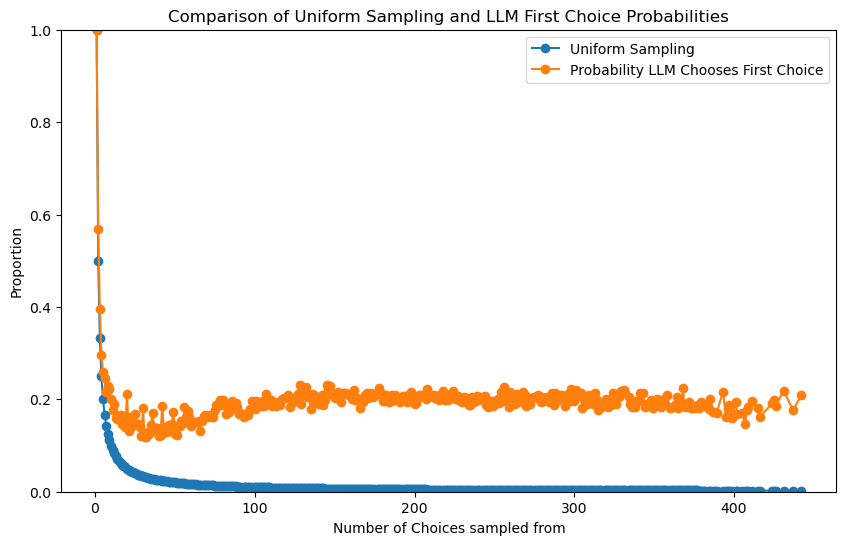

In [45]:
plot_choice_probabilities(random_df)



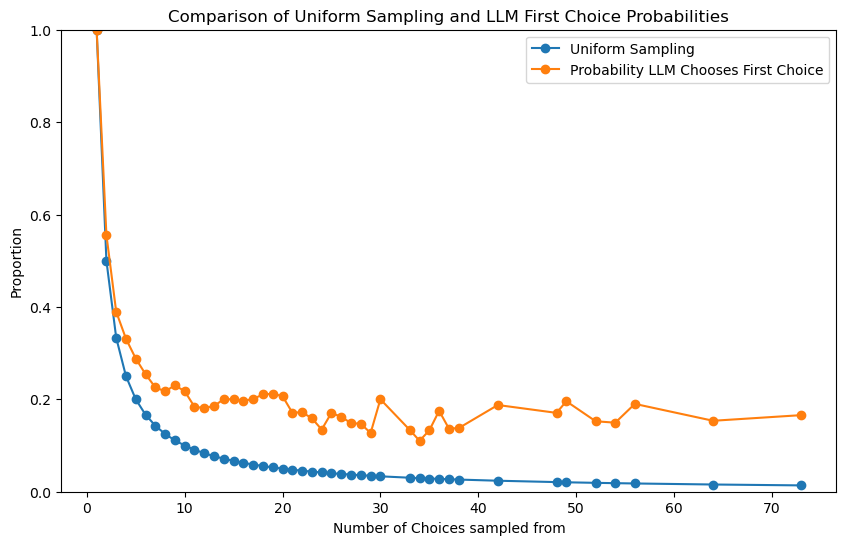

In [46]:
plot_choice_probabilities(heuristic_df)

In [49]:

# Get unique decision types for both random and heuristic dataframes
random_decision_types = random_df['decision_type'].unique()
heuristic_decision_types = heuristic_df['decision_type'].unique()

# Create dictionaries to hold DataFrames for each decision type
random_decision_type_dfs = {}
heuristic_decision_type_dfs = {}

# Loop through each decision type and create separate DataFrames for random
for decision_type in random_decision_types:
    random_decision_type_dfs[decision_type] = random_df[random_df['decision_type'] == decision_type]

# Loop through each decision type and create separate DataFrames for heuristic 
for decision_type in heuristic_decision_types:
    heuristic_decision_type_dfs[decision_type] = heuristic_df[heuristic_df['decision_type'] == decision_type]



In [50]:
def plot_soldier_distribution(decision_type_dfs):
    # Extract the number of soldiers Player 3 has
    decision_type_dfs['attack_phase_skip_or_attack']['player_3_soldiers'] = decision_type_dfs['attack_phase_skip_or_attack']['game_state'].apply(lambda x: x['soldiers_per_player']['Player 3'])

    # Separate the data into two groups: Attack and Skip
    attack_soldiers = decision_type_dfs['attack_phase_skip_or_attack'][decision_type_dfs['attack_phase_skip_or_attack']['selected_choice'] == 'Attack']['player_3_soldiers']
    skip_soldiers = decision_type_dfs['attack_phase_skip_or_attack'][decision_type_dfs['attack_phase_skip_or_attack']['selected_choice'] == 'Skip']['player_3_soldiers']

    # Plot the distribution of the number of soldiers for each choice
    plt.figure(figsize=(12, 6))
    plt.hist(attack_soldiers, bins=20, alpha=0.5, label='Attack', color='blue', edgecolor='black')
    plt.hist(skip_soldiers, bins=20, alpha=0.5, label='Skip', color='red', edgecolor='black')

    plt.xlabel('Number of Soldiers Player 3 Has')
    plt.ylabel('Frequency')
    plt.title('Distribution of Number of Soldiers for Player 3: Attack vs. Skip')
    plt.legend()
    plt.show()

/var/folders/pt/fkyd8dd91bj1qmt6c8pvp6k80000gp/T/ipykernel_7594/111569096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_type_dfs['attack_phase_skip_or_attack']['player_3_soldiers'] = decision_type_dfs['attack_phase_skip_or_attack']['game_state'].apply(lambda x: x['soldiers_per_player']['Player 3'])


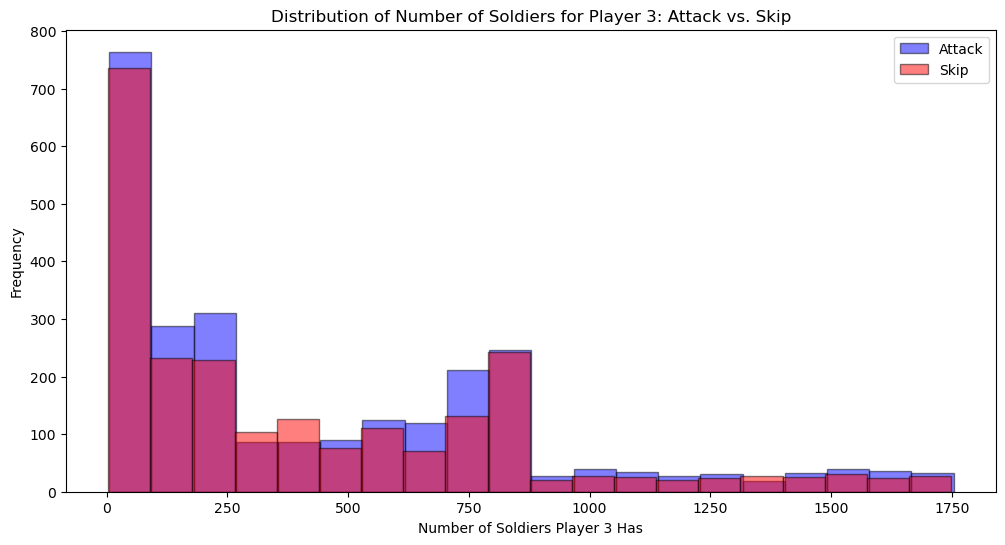

In [51]:
plot_soldier_distribution(random_decision_type_dfs)

/var/folders/pt/fkyd8dd91bj1qmt6c8pvp6k80000gp/T/ipykernel_7594/111569096.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_type_dfs['attack_phase_skip_or_attack']['player_3_soldiers'] = decision_type_dfs['attack_phase_skip_or_attack']['game_state'].apply(lambda x: x['soldiers_per_player']['Player 3'])


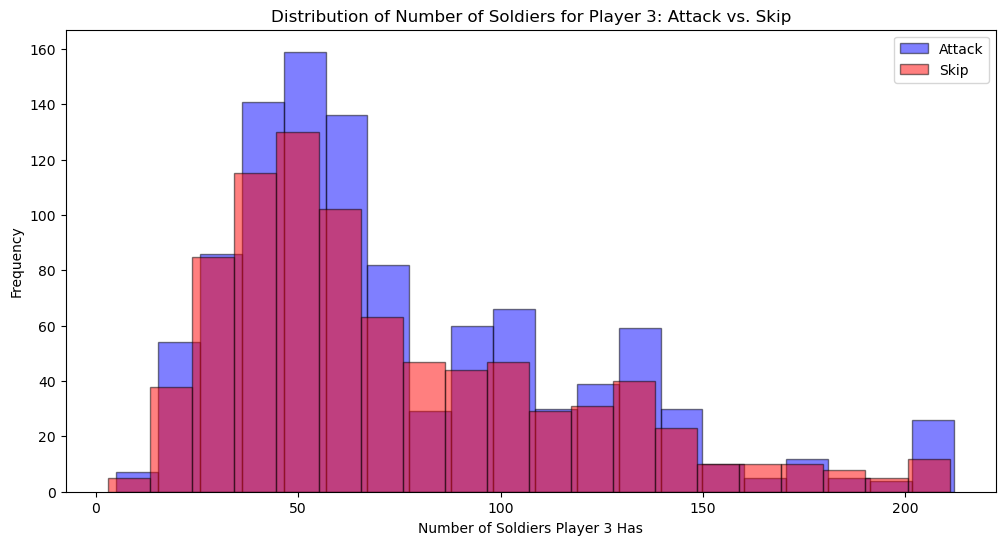

In [52]:
plot_soldier_distribution(heuristic_decision_type_dfs)

In [53]:
def plot_attack_probability_by_turn(decision_type_dfs):
    # Extract the turn number and whether the choice is "Attack"
    decision_type_dfs['attack_phase_skip_or_attack']['turn_number'] = decision_type_dfs['attack_phase_skip_or_attack']['game_state'].apply(lambda x: x['turn_number'])
    decision_type_dfs['attack_phase_skip_or_attack']['is_attack'] = decision_type_dfs['attack_phase_skip_or_attack']['selected_choice'].apply(lambda x: x == 'Attack')

    # Group by turn number and calculate the probability of choosing "Attack"
    attack_probabilities_by_turn = decision_type_dfs['attack_phase_skip_or_attack'].groupby('turn_number')['is_attack'].mean()

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(attack_probabilities_by_turn.index, attack_probabilities_by_turn.values, marker='o')
    plt.xlabel('Turn Number')
    plt.ylabel('Probability of Choosing Attack')
    plt.title('Probability of Choosing Attack vs. Turn Number')
    plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better comparison
    plt.grid(True)
    plt.show()

/var/folders/pt/fkyd8dd91bj1qmt6c8pvp6k80000gp/T/ipykernel_7594/2551442758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_type_dfs['attack_phase_skip_or_attack']['turn_number'] = decision_type_dfs['attack_phase_skip_or_attack']['game_state'].apply(lambda x: x['turn_number'])
/var/folders/pt/fkyd8dd91bj1qmt6c8pvp6k80000gp/T/ipykernel_7594/2551442758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_type_dfs['attack_phase_skip_or_attack']['is_attack'] = decision_type_dfs['attack_phase

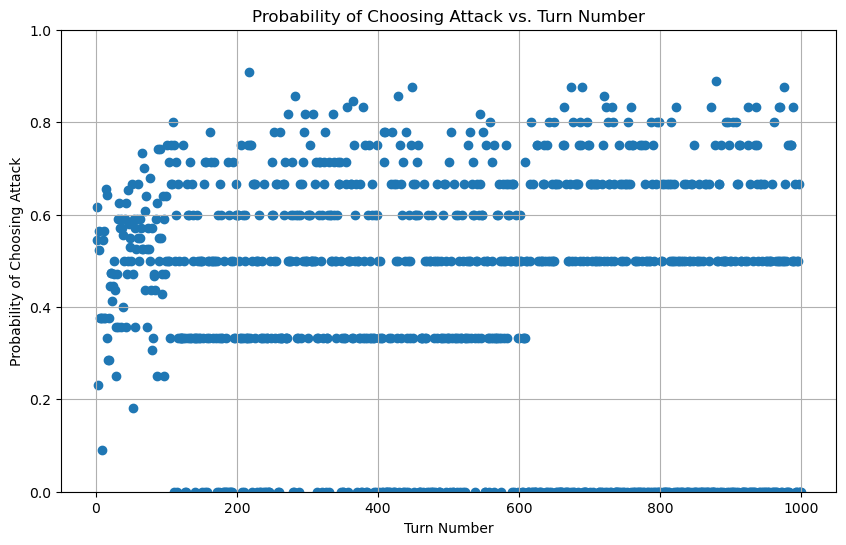

In [54]:
plot_attack_probability_by_turn(random_decision_type_dfs)

/var/folders/pt/fkyd8dd91bj1qmt6c8pvp6k80000gp/T/ipykernel_7594/2551442758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_type_dfs['attack_phase_skip_or_attack']['turn_number'] = decision_type_dfs['attack_phase_skip_or_attack']['game_state'].apply(lambda x: x['turn_number'])
/var/folders/pt/fkyd8dd91bj1qmt6c8pvp6k80000gp/T/ipykernel_7594/2551442758.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decision_type_dfs['attack_phase_skip_or_attack']['is_attack'] = decision_type_dfs['attack_phase

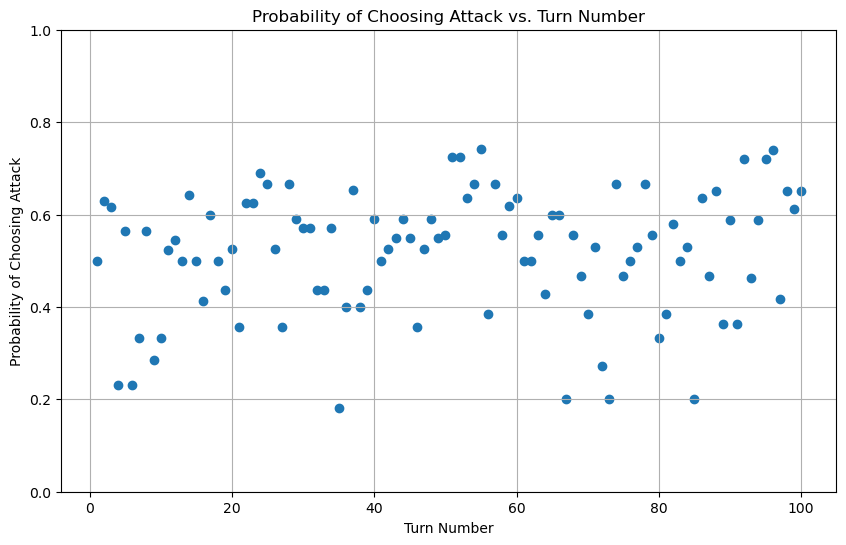

In [55]:
plot_attack_probability_by_turn(heuristic_decision_type_dfs)

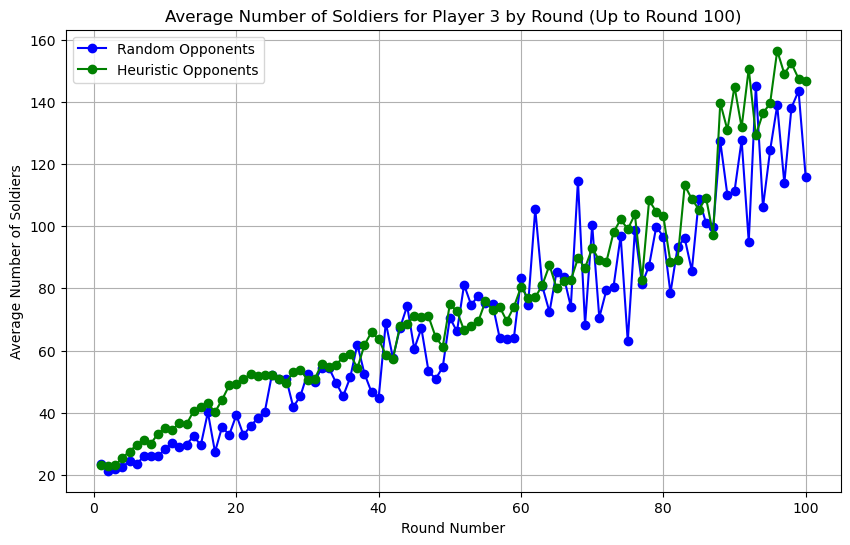

In [63]:
import matplotlib.pyplot as plt

def plot_average_soldiers_by_round(random_df, heuristic_df):
    # Extract the turn number and number of soldiers for Player 3
    random_df['turn_number'] = random_df['game_state'].apply(lambda x: x['turn_number'])
    random_df['player_3_soldiers'] = random_df['game_state'].apply(lambda x: x['soldiers_per_player']['Player 3'])
    
    heuristic_df['turn_number'] = heuristic_df['game_state'].apply(lambda x: x['turn_number'])
    heuristic_df['player_3_soldiers'] = heuristic_df['game_state'].apply(lambda x: x['soldiers_per_player']['Player 3'])

    # Filter for rounds up to 100
    random_df = random_df[random_df['turn_number'] <= 100]
    heuristic_df = heuristic_df[heuristic_df['turn_number'] <= 100]

    # Group by turn number and calculate the average number of soldiers for each round
    random_avg_soldiers_by_round = random_df.groupby('turn_number')['player_3_soldiers'].mean()
    heuristic_avg_soldiers_by_round = heuristic_df.groupby('turn_number')['player_3_soldiers'].mean()

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(random_avg_soldiers_by_round.index, random_avg_soldiers_by_round.values, label='Random Opponents', color='blue', marker='o')
    plt.plot(heuristic_avg_soldiers_by_round.index, heuristic_avg_soldiers_by_round.values, label='Heuristic Opponents', color='green', marker='o')
    plt.xlabel('Round Number')
    plt.ylabel('Average Number of Soldiers')
    plt.title('Average Number of Soldiers for Player 3 by Round (Up to Round 100)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the dataframes
plot_average_soldiers_by_round(random_df, heuristic_df)